In [1]:
import numpy as np 
import matplotlib.pyplot as plt 


### Loss

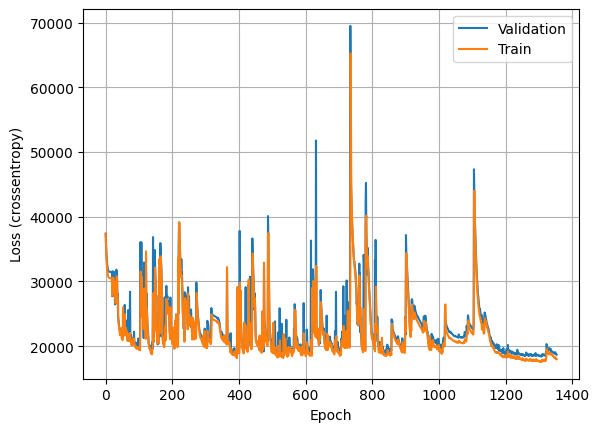

In [4]:
losses=np.load("/its/home/drs25/Quadruped/Code/UBERMODEL/models/regressive_lstm_loss.npy")
loss_train=losses[:,0]
loss_val=losses[:,1]
plt.plot(loss_val,label="Validation")
plt.plot(loss_train,label="Train")
plt.grid()
plt.ylabel("Loss (crossentropy)")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.show()